Mayo 2021
# Airspace capacity
Versión simplificada del problema de airline scheduling.

El problema de airline scheduling, como su nombre lo indica depende de los horarios de despegue y aterrizaje de los aviones en cada ruta. En este caso, para reducir la complejidad no tomaremos en cuenta esto, si no simplemente la cantidad máxima de personas que pueden viajar de un areopuerto a otro.

In [1]:
import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
url = 'https://raw.githubusercontent.com/sid-7/Airline_Maximum_Flow/master/flights.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [16]:
df

,Source,Destination,Depature,Arrival,capacity
0,ORD,ATL,530,829,185
1,BOS,ATL,545,854,185
2,LAX,SEA,600,900,165
3,PHX,ATL,600,1127,185
4,SFO,ATL,600,1332,230
...,...,...,...,...,...
146,BOS,ORD,1330,1533,160
147,BOS,ORD,600,805,160
148,BOS,JFK,601,726,102
149,BOS,JFK,1217,1339,128


In [17]:
data = df.values

## Solución con ffmaxflow
Supongamos que queremos saber el el máximo número de personas que pueden viajar de Denver a Atlanta.

In [5]:
import ffmaxflow as ff

In [6]:
red = ff.create_flow_network()

In [7]:
unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
unique_nodes

array(['ATL', 'BOS', 'DEN', 'IAD', 'JFK', 'LAX', 'ORD', 'PHX', 'SEA',
       'SFO'], dtype=object)

In [8]:
for node in unique_nodes:
    
    if node == 'DEN':
        red.create_vertex('{}'.format(node), True, False)
    
    elif node == 'ATL':
        red.create_vertex('{}'.format(node), False, True)
    
    else:
        red.create_vertex('{}'.format(node), False, False)

In [9]:
len(red.vertices)

10

In [10]:
for row in range(data.shape[0]):
    red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])

In [32]:
%%time
red.MaxFlow()

CPU times: user 1min 1s, sys: 3.64 ms, total: 1min 1s
Wall time: 1min 1s


10179

## Solución con ffmaxc

In [87]:
!pip install ../ffmaxc/

Processing /home/diramtz/Documents/Optimizacion/ProyectoFinal_MaxFlow/ffmaxc
  Created wheel for UNKNOWN: filename=UNKNOWN-0.0.0-cp38-cp38-linux_x86_64.whl size=250160 sha256=aa61e104d6e87028b616f26ae7aca5058442fceb773a58883c858217bbd07f6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2uzi3q1/wheels/64/ec/00/07fbc8f81d14bd6e084a678ffbbd60843bf4aaa867d0489e69
Successfully built UNKNOWN
  Attempting uninstall: UNKNOWN
    Found existing installation: UNKNOWN 0.0.0
    Uninstalling UNKNOWN-0.0.0:
      Successfully uninstalled UNKNOWN-0.0.0


In [12]:
import ffmaxc as ffc

In [21]:
red = ffc.create_flow_network()

In [22]:
unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
unique_nodes

array(['ATL', 'BOS', 'DEN', 'IAD', 'JFK', 'LAX', 'ORD', 'PHX', 'SEA',
       'SFO'], dtype=object)

In [23]:
for node in unique_nodes:
    
    if node == 'DEN':
        red.create_vertex('{}'.format(node), True, False)
    
    elif node == 'ATL':
        red.create_vertex('{}'.format(node), False, True)
    
    else:
        red.create_vertex('{}'.format(node), False, False)

In [24]:
len(red.vertices)

10

In [25]:
for row in range(data.shape[0]):
    red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])

In [26]:
%%time
red.MaxFlow()

CPU times: user 56.3 s, sys: 148 ms, total: 56.5 s
Wall time: 56.2 s


10179.0

## Solución con networkx

Ahora con ayuda de la paquetería de networkx comprobamos que nuestros paquetes den el resultado correcto.

In [18]:
G = nx.DiGraph()

In [19]:
for row in range(data.shape[0]):
    G.add_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), capacity = data[row,2])

In [20]:
flow_value, flow_dict = nx.maximum_flow(G, 'DEN', 'ATL')

In [21]:
flow_value

9638

Notamos que el resultado devuelto por networks no se parece en nada al que arrojaron nuestros paquetes, de hecho ni siquiera tiene el mismo orden de magnitud.

Después de investigar un poco, dimos con el problema. Cuando tienes varios arcos entre un par específico de nodos, al definir el arco utilizamos los mismo nombres de estos dos nodos una y otra vez. La diferencia entre `ffmaxflow` y `networkx` es que `ffmaxflow` guarda cada uno de estos vértices de manera independiente, sin importar que sus parámetros sean los mismos, mientras que `networkx` sobrescribe cada arco que llama a un par de nodos que ya se tenían guardados bajo otro arco.

Entonces, si sumamos todas las capacidades (cantidad de pasajeros) por ruta y metemos esta nueva red resumida a `networkx` deberíamos de obtener el mismo resultado que con `ffmaxflow`.

### Sumando todos los pasajeros de la ruta

In [22]:
suma_df = df.groupby(['Source', 'Destination'])['capacity'].sum().reset_index()
suma_df

,Source,Destination,capacity
0,ATL,BOS,2035
1,ATL,DEN,1440
2,ATL,IAD,884
3,ATL,JFK,1350
4,ATL,ORD,2235
...,...,...,...
67,SFO,IAD,760
68,SFO,JFK,102
69,SFO,ORD,1930
70,SFO,PHX,1254


In [23]:
data = suma_df.values

In [24]:
G = nx.DiGraph()

In [25]:
for row in range(data.shape[0]):
    G.add_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), capacity = data[row,2])

In [26]:
flow_value, flow_dict = nx.maximum_flow(G, 'DEN', 'ATL')

In [27]:
flow_value

10179

Y ahora sí, vemos que se obtuvo el mismo resultado que con `ffmaxflow` y `ffmaxc`, por lo que nuestra  implementación es correcta.

## Gráfica de las rutas

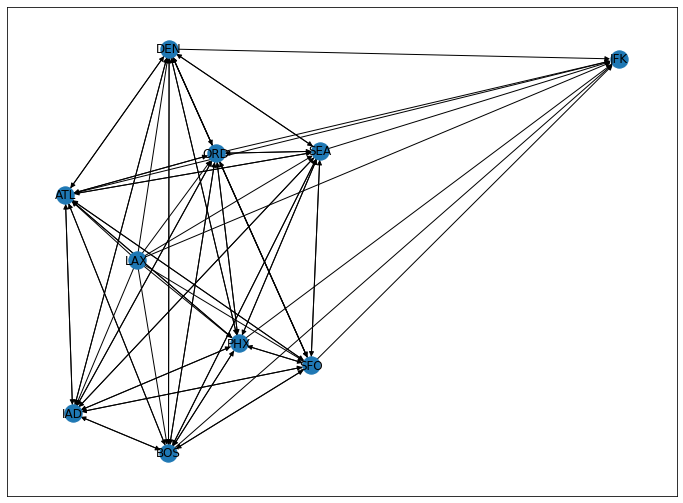

In [86]:
plt.figure(figsize = (12,9))
nx.draw_networkx(G)

## Función
También podemos crear una función para que sea más fácil y rápido calcular el máximo flujo de pasajeros de un aeropuerto a otro.

In [34]:
def calculate_flow(source_airport, destiny_airport, data):
    
    red = ff.create_flow_network()
    unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
    
    for node in unique_nodes:
    
        if node == source_airport:
            red.create_vertex('{}'.format(node), True, False)
    
        elif node == destiny_airport:
            red.create_vertex('{}'.format(node), False, True)
    
        else:
            red.create_vertex('{}'.format(node), False, False)
        
    for row in range(data.shape[0]):
        red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])
    
    red.MaxFlow()

In [37]:
def calculate_flowc(source_airport, destiny_airport, data):
    
    red = ffc.create_flow_network()
    unique_nodes = np.unique(np.hstack((data[:,0],data[:,1])))
    
    for node in unique_nodes:
    
        if node == source_airport:
            red.create_vertex('{}'.format(node), True, False)
    
        elif node == destiny_airport:
            red.create_vertex('{}'.format(node), False, True)
    
        else:
            red.create_vertex('{}'.format(node), False, False)
        
    for row in range(data.shape[0]):
        red.create_edge('{}'.format(data[row,0]), '{}'.format(data[row,1]), data[row,4])
    
    red.MaxFlow()

## Ejemplos

+ De Denver a Atlanta

In [36]:
%%time
calculate_flow('DEN', 'ATL', data)

CPU times: user 59.8 s, sys: 0 ns, total: 59.8 s
Wall time: 59.9 s


In [38]:
%%time
calculate_flowc('DEN', 'ATL', data)

CPU times: user 57 s, sys: 200 ms, total: 57.2 s
Wall time: 57.7 s


+ De Boston a Seattle

In [39]:
%%time
calculate_flow('BOS', 'SEA', data)

CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 1min 25s


In [40]:
%%time
calculate_flowc('BOS', 'SEA', data)

CPU times: user 1min 21s, sys: 239 ms, total: 1min 21s
Wall time: 1min 25s


+ De Washington a Phoenix

In [36]:
%%time
calculate_flow('IAD', 'PHX', data)

CPU times: user 59.8 s, sys: 0 ns, total: 59.8 s
Wall time: 59.9 s


In [38]:
%%time
calculate_flowc('IAD', 'PHX', data)

CPU times: user 57 s, sys: 200 ms, total: 57.2 s
Wall time: 57.7 s


+ De San Francisco a Atlanta

In [41]:
%%time
calculate_flow('SFO', 'ATL', data)

CPU times: user 2min 4s, sys: 3.83 ms, total: 2min 4s
Wall time: 2min 16s


In [42]:
%%time
calculate_flowc('SFO', 'ATL', data)

CPU times: user 2min, sys: 304 ms, total: 2min
Wall time: 2min 7s


+ De Boston a Phoenix

In [43]:
%%time
calculate_flow('BOS', 'PHX', data)

CPU times: user 14min 14s, sys: 43.4 ms, total: 14min 14s
Wall time: 15min 17s


In [44]:
%%time
calculate_flowc('BOS', 'PHX', data)

CPU times: user 13min 54s, sys: 2.3 s, total: 13min 56s
Wall time: 15min 9s
